## Notebook to run post processing of differential expression in single-cell data for glmm based analysis

basically 
- read glmm results per region and cell-type and then integrate them
- apply B&H FDR 
- take a look at overlap between brain regions and cell-types do some sample plotting

In [1]:
!date

Mon Nov  8 10:15:17 EST 2021


#### import libraries and set notebook variables

In [2]:
import anndata as ad
import numpy as np
import pandas as pd
import scanpy as sc
import statsmodels.stats.multitest as smm
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import rc_context
import json

import warnings
warnings.simplefilter('ignore')

import random
random.seed(420)

In [4]:
# parameters
cohort = 'aging'
assay = 'RNA'

# directories for initial setup
home_dir = '/labshare/raph/datasets/adrd_neuro'
wrk_dir = f'{home_dir}/{cohort}'
quants_dir = f'{wrk_dir}/demux'
results_dir = f'{wrk_dir}/results'

# in files
data_file = f'{quants_dir}/{cohort}.pegasus.leiden_085.Age_group_young_old.h5ad'
tissue_out_file = '{this_dir}/{chrt}.{name}.glmm_age_diffs.csv'

# out files
results_file = f'{results_dir}/{cohort}.glmm_zi_age_diffs.csv'
results_fdr_file = f'{results_dir}/{cohort}.glmm_zi_age_diffs_fdr.csv'

# constants
region_obs_feature = 'Brain_region'
celltype_obs_feature = 'new_anno'
min_cell_count = 3
young_age_limit = 30.0
sns.set_theme(style='white', palette='Paired', font_scale=1.2) 

#### analysis functions

In [5]:
def read_glmm_results(group_name: str, group_type: str) -> pd.DataFrame:
    this_file = tissue_out_file.format(this_dir=results_dir, chrt=cohort, 
                                       name=group_name.replace(" ", "_"))
    this_df = pd.read_csv(this_file)
    this_df['tissue'] = group_name
    this_df['type'] = 'brain_region' if group_type == region_obs_feature else 'cell_type'     
    return this_df

def compute_bh_fdr(df: pd.DataFrame, alpha: float=0.05, p_col: str='p-value',
                   method: str='fdr_bh', verbose: bool=True) -> pd.DataFrame:
    ret_df = df.copy()
    test_adjust = smm.multipletests(np.array(ret_df[p_col]), alpha=alpha, 
                                    method=method)
    ret_df[method] = test_adjust[1]
    if verbose:
        print(f'total significant after correction: {ret_df.loc[ret_df[method] < alpha].shape}')
    return ret_df

def plot_feature_by_age_group(df: pd.DataFrame, x_term: str, y_term: str):
    plt.figure(figsize=(9,9))
    sns.boxenplot(x=x_term,y=y_term, scale='exponential', data=df,
                  k_depth='trustworthy')

    grsplt = sns.stripplot(x=x_term,y=y_term, data=df, alpha=0.75,
                           jitter=True, color='darkgrey')
    plt.title(f'{y_term} ~ {x_term}', fontsize='large') 
    plt.xlabel(x_term)
    plt.ylabel(y_term)
    plt.show()
    
def plot_feature_by_sample(df: pd.DataFrame, x_term: str, y_term: str):
    # set up order by young then old
    temp = df.groupby('Age_group')['Sample_id'].unique()
    this_list = temp['young'].to_list() + temp['old'].to_list()    
    plt.figure(figsize=(9,9))
    sns.boxenplot(x='Sample_id',y=y_term, scale='exponential', data=df,
                  k_depth='trustworthy', hue=x_term, order=this_list)
    grsplt = sns.stripplot(x='Sample_id',y=y_term, data=df, alpha=0.75,
                           jitter=True, color='darkgrey', order=this_list)
    plt.xticks(rotation=75)
    plt.title(f'{y_term} ~ {x_term}', fontsize='large') 
    plt.xlabel('Sample')
    plt.ylabel(y_term)
    plt.show()    
    
def volcano_plot(df: pd.DataFrame, x_term: str='coef', y_term: str='p-value', 
                 alpha: float=0.05, adj_p_col: str='fdr_bh', title: str=None, 
                 filter_nseeff: bool=True, extreme_size: float=10.0):
    if filter_nseeff:
        df = df.loc[((-extreme_size < df[x_term]) & 
                    (df[x_term] < extreme_size) &
                    (~df['z'].isna()) | 
                    (df[adj_p_col] < alpha))]
    plt.figure(figsize=(9,9))
    log_pvalue = -np.log10(df[y_term])
    is_sig = df[adj_p_col] < alpha
    sns.scatterplot(x=x_term, y=log_pvalue, data=df, hue=is_sig)
    plt.title(title)
    plt.xlabel('effect')
    plt.ylabel('-log10(p-value)')
    plt.show()
    
def prep_plot_feature(data: ad.AnnData, feature_results: pd.Series, 
                      group: str='old', filter_zeros: bool=False):
    this_type = region_obs_feature if feature_results.type == 'brain_region' else celltype_obs_feature   
    this_ad = subset_ad_by_type(data, feature_results.tissue, this_type)
    this_df = convert_ad_to_df(this_ad)
    if filter_zeros:
        this_df = this_df.loc[this_df[feature_results.feature] > 0]
    print(feature_results)
    sns.set_theme(style='white', palette='Paired', font_scale=1.2)
    plot_feature_by_age_group(this_df, group, feature_results.feature)
    plot_feature_by_sample(this_df, group, feature_results.feature)
    
def subset_ad_by_type(data: ad.AnnData, group_name: str, type_name: str,
                      reapply_filter: bool=True, min_cell_count: int=3,
                      verbose: bool=False) -> ad.AnnData:
    this_data = data[data.obs[type_name] == group_name].copy()
    shape_before = this_data.shape
    if reapply_filter:
        sc.pp.filter_genes(this_data, min_counts=min_cell_count)
        sc.pp.filter_cells(this_data, min_counts=min_cell_count)
        shape_after = this_data.shape
    if verbose:
        print(f'shape before and after: {shape_before} {shape_after}')
        print(this_data)
    return this_data

def convert_ad_to_df(data: ad.AnnData, young_age_limit: float=30.0, 
                     verbose: bool=False) -> pd.DataFrame:
    data_df = data.to_df()
    annots = data.obs[['Brain_region', 'Age','Age_group', 'pool_name', 
                       'Sample_id', 'Sex', 'donor_id']].copy()
    annots['old'] = np.where((annots['Age'] > young_age_limit), 1, 0)
    annots['female'] = np.where((annots['Sex'] == 'Female'), 1, 0)
    this_df = None
    if data_df.index.equals(annots.index):
        this_df = pd.concat([data_df, annots], axis='columns')
        if verbose:
            print(this_df.shape)
            display(this_df.head())
    return this_df

#### read the anndata (h5ad) file

In [6]:
%%time
adata = sc.read(data_file, cache=True)
print(adata)

Only considering the two last: ['.Age_group_young_old', '.h5ad'].
Only considering the two last: ['.Age_group_young_old', '.h5ad'].
AnnData object with n_obs × n_vars = 167945 × 35441
    obs: 'pool_name', 'Sample_id', 'Tissue_source', 'Brain_region', 'Clinical_diagnosis', 'Age', 'Sex', 'donor_id', 'lane_num', 'Channel', 'n_genes', 'n_counts', 'percent_mito', 'scale', 'Group', 'leiden_labels', 'anno', 'leiden_labels_085', 'new_anno', 'Age_group'
    var: 'n_cells', 'percent_cells', 'robust', 'highly_variable_features', 'mean', 'var', 'hvf_loess', 'hvf_rank'
    uns: 'Channels', 'Groups', 'PCs', 'W_diffmap', 'W_pca_harmony', 'c2gid', 'df_qcplot', 'diffmap_evals', 'diffmap_knn_distances', 'diffmap_knn_indices', 'genome', 'gncells', 'leiden_resolution', 'modality', 'ncells', 'norm_count', 'pca', 'pca_features', 'pca_harmony_knn_distances', 'pca_harmony_knn_indices', 'stdzn_max_value', 'stdzn_mean', 'stdzn_std'
    obsm: 'X_diffmap', 'X_fle', 'X_pca', 'X_pca_harmony', 'X_phi', 'X_umap', 'X

#### take a look at the cell counts by cell type

In [7]:
# get cell counts by 'categories'
categories = ['Brain_region', 'new_anno']
for this_cat in categories:
    print(adata.obs[this_cat].value_counts())

Entorhinal cortex        54399
Putamen                  49625
Subventricular zone      36610
Middle temporal gyrus    27311
Name: Brain_region, dtype: int64
Oligodendrocyte-1    36479
SPN D1               15379
SPN D2               15280
Oligodendrocyte-2    12844
Astrocyte            12208
ExN CUX2 LAMP5        9055
uncertain             7548
InN ADARB2 VIP        7014
ExN FEZF2             6842
OPC                   6682
ExN RORB THEMIS       5130
InN LHX6 PVALB        4566
Radial Glia           3669
Microglia             3265
InN ADARB2 LAMP5      3216
ExN CUX2 ADARB2       3066
InN LHX6 SST          2937
uncertain-2           2677
SPN D1-2              2388
Endothelial           2246
ExN RORB              1966
ExN LAMP5             1963
Astrocyte-GFAP-Hi      599
SPN D2-2               465
ExN THEMIS             461
Name: new_anno, dtype: int64


#### get sample counts per age group by  counts by 'categories'

In [8]:
for this_cat in categories:
    print(adata.obs.groupby([this_cat,'Age_group'])['Sample_id'].nunique())

Brain_region           Age_group
Entorhinal cortex      old          6
                       young        6
Middle temporal gyrus  old          7
                       young        5
Putamen                old          7
                       young        5
Subventricular zone    old          6
                       young        6
Name: Sample_id, dtype: int64
new_anno           Age_group
Astrocyte          old          26
                   young        22
Astrocyte-GFAP-Hi  old           0
                   young         1
Endothelial        old          26
                   young        22
ExN CUX2 ADARB2    old           8
                   young         8
ExN CUX2 LAMP5     old          24
                   young        20
ExN FEZF2          old          15
                   young        13
ExN LAMP5          old           7
                   young         6
ExN RORB           old           8
                   young         8
ExN RORB THEMIS    old          14
         

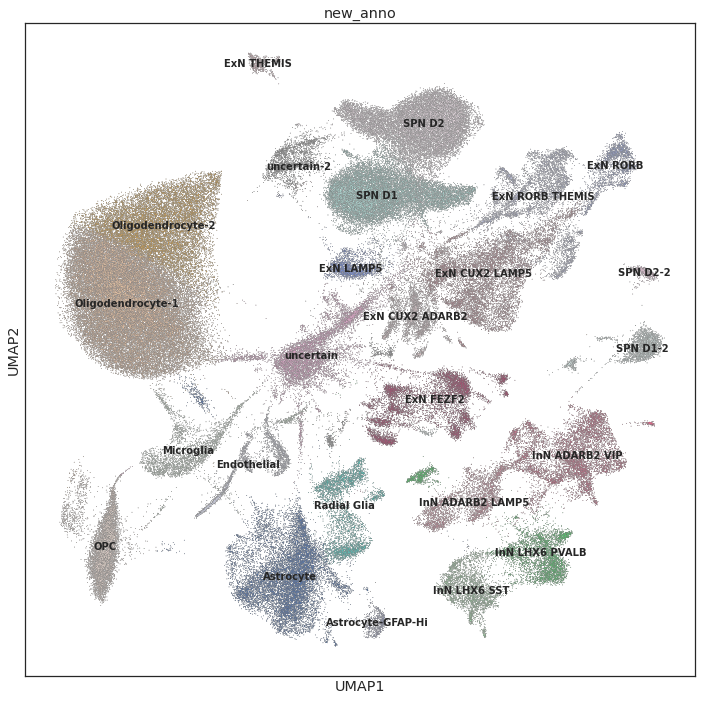

In [9]:
with rc_context({'figure.figsize': (12, 12)}):
    sc.pl.umap(adata, color=[celltype_obs_feature], legend_loc='on data', 
               add_outline=True, legend_fontsize=10)

##### find cell-types not used in analysis
remove them, and then refilter genes based on cell count

In [10]:
found_uncertain = [x for x in adata.obs[celltype_obs_feature].unique().to_list() 
                   if 'uncertain' in x] + ['Astrocyte-GFAP-Hi']
print(found_uncertain)
adata = adata[~adata.obs[celltype_obs_feature].isin(found_uncertain ), :]
sc.pp.filter_genes(adata, min_cells=min_cell_count)
adata

['uncertain', 'uncertain-2', 'Astrocyte-GFAP-Hi']


Trying to set attribute `.var` of view, copying.


AnnData object with n_obs × n_vars = 157121 × 34609
    obs: 'pool_name', 'Sample_id', 'Tissue_source', 'Brain_region', 'Clinical_diagnosis', 'Age', 'Sex', 'donor_id', 'lane_num', 'Channel', 'n_genes', 'n_counts', 'percent_mito', 'scale', 'Group', 'leiden_labels', 'anno', 'leiden_labels_085', 'new_anno', 'Age_group'
    var: 'n_cells', 'percent_cells', 'robust', 'highly_variable_features', 'mean', 'var', 'hvf_loess', 'hvf_rank'
    uns: 'Channels', 'Groups', 'PCs', 'W_diffmap', 'W_pca_harmony', 'c2gid', 'df_qcplot', 'diffmap_evals', 'diffmap_knn_distances', 'diffmap_knn_indices', 'genome', 'gncells', 'leiden_resolution', 'modality', 'ncells', 'norm_count', 'pca', 'pca_features', 'pca_harmony_knn_distances', 'pca_harmony_knn_indices', 'stdzn_max_value', 'stdzn_mean', 'stdzn_std', 'new_anno_colors'
    obsm: 'X_diffmap', 'X_fle', 'X_pca', 'X_pca_harmony', 'X_phi', 'X_umap', 'X_umap_085'
    varm: 'de_res', 'gmeans', 'gstds', 'means', 'partial_sum'

### read the diff by age results by region and cell-type

In [11]:
%%time
glmm_results = None
for this_type in categories:
    for this_tissue in adata.obs[this_type].unique():
        glmm_results = pd.concat([glmm_results, read_glmm_results(this_tissue, 
                                                                  this_type)])

CPU times: user 648 ms, sys: 27.4 ms, total: 675 ms
Wall time: 2.09 s


In [12]:
print(glmm_results.shape)
display(glmm_results.head())

(226712, 9)


,feature,intercept,coef,stderr,z,p-value,log2_fc,tissue,type
0,CLMAT3,0.027721,-0.008033,0.005942,-1.351831,0.176430,-0.493672,Middle temporal gyrus,brain_region
1,SLC26A11,0.339170,0.130978,0.037491,3.493591,0.000477,0.471106,Middle temporal gyrus,brain_region
2,AP002381.2,0.207773,0.025675,0.028384,0.904562,0.365698,0.168093,Middle temporal gyrus,brain_region
3,TEX10,0.668419,0.021417,0.081008,0.264377,0.791489,0.045500,Middle temporal gyrus,brain_region
4,COQ5,0.215407,0.000930,0.014507,0.064107,0.948885,0.006215,Middle temporal gyrus,brain_region


In [13]:
glmm_results['tissue'].value_counts()

Subventricular zone      18066
Putamen                  17236
Entorhinal cortex        16025
Middle temporal gyrus    14897
InN ADARB2 VIP           12338
ExN CUX2 LAMP5           11613
ExN RORB THEMIS          10836
ExN CUX2 ADARB2          10789
SPN D1                   10249
InN LHX6 PVALB           10040
SPN D2                    9828
Radial Glia               9300
ExN FEZF2                 9291
Oligodendrocyte-1         7925
InN LHX6 SST              7768
ExN RORB                  7340
Astrocyte                 6841
InN ADARB2 LAMP5          6438
Oligodendrocyte-2         6323
SPN D1-2                  5564
OPC                       4275
Microglia                 4236
ExN THEMIS                3643
Endothelial               2647
SPN D2-2                  2056
ExN LAMP5                 1148
Name: tissue, dtype: int64

#### compute the FDR values

In [14]:
glmm_results['p-value'] = glmm_results['p-value'].fillna(1)
glmm_results = compute_bh_fdr(glmm_results)
print(glmm_results.shape)
display(glmm_results.head())

total significant after correction: (1957, 10)
(226712, 10)


,feature,intercept,coef,stderr,z,p-value,log2_fc,tissue,type,fdr_bh
0,CLMAT3,0.027721,-0.008033,0.005942,-1.351831,0.176430,-0.493672,Middle temporal gyrus,brain_region,0.662670
1,SLC26A11,0.339170,0.130978,0.037491,3.493591,0.000477,0.471106,Middle temporal gyrus,brain_region,0.052653
2,AP002381.2,0.207773,0.025675,0.028384,0.904562,0.365698,0.168093,Middle temporal gyrus,brain_region,0.828004
3,TEX10,0.668419,0.021417,0.081008,0.264377,0.791489,0.045500,Middle temporal gyrus,brain_region,1.000000
4,COQ5,0.215407,0.000930,0.014507,0.064107,0.948885,0.006215,Middle temporal gyrus,brain_region,1.000000


#### count of significant genes by brain region

In [16]:
print(glmm_results.loc[glmm_results['fdr_bh'] < 0.05]['tissue'].nunique())
glmm_results.loc[glmm_results['fdr_bh'] < 0.05]['tissue'].value_counts()

25


ExN CUX2 ADARB2          330
InN LHX6 SST             213
ExN RORB                 209
InN LHX6 PVALB           151
ExN CUX2 LAMP5           123
OPC                       89
Microglia                 89
ExN THEMIS                83
InN ADARB2 LAMP5          74
SPN D1                    67
ExN LAMP5                 65
ExN FEZF2                 61
ExN RORB THEMIS           57
Middle temporal gyrus     55
Oligodendrocyte-1         52
Entorhinal cortex         49
SPN D2                    42
Astrocyte                 35
Radial Glia               33
Oligodendrocyte-2         22
SPN D2-2                  16
Endothelial               13
InN ADARB2 VIP            10
SPN D1-2                  10
Putamen                    9
Name: tissue, dtype: int64

#### save the full results

In [17]:
glmm_results.to_csv(results_file, index=False)

#### save the statistically significant results

In [18]:
glmm_results.loc[glmm_results['fdr_bh'] < 0.05].to_csv(results_fdr_file, index=False)

In [19]:
display(glmm_results.loc[glmm_results['fdr_bh'] < 0.05].head())

,feature,intercept,coef,stderr,z,p-value,log2_fc,tissue,type,fdr_bh
259,L3MBTL4,2.233813,-0.400243,0.054432,-7.353132,1.936150e-13,-0.284853,Middle temporal gyrus,brain_region,8.606834e-10
461,STK33,0.296583,0.160024,0.039976,4.002990,6.254704e-05,0.622519,Middle temporal gyrus,brain_region,1.442540e-02
989,CD209,0.001044,0.004999,0.001363,3.668002,2.444532e-04,2.532990,Middle temporal gyrus,brain_region,3.468114e-02
1298,ROBO1,3.430531,-0.444843,0.108907,-4.084634,4.414627e-05,-0.200369,Middle temporal gyrus,brain_region,1.147754e-02
1305,ALDH1A1,0.214506,0.135463,0.028388,4.771805,1.825821e-06,0.706210,Middle temporal gyrus,brain_region,1.178208e-03


#### visualize volcano plots

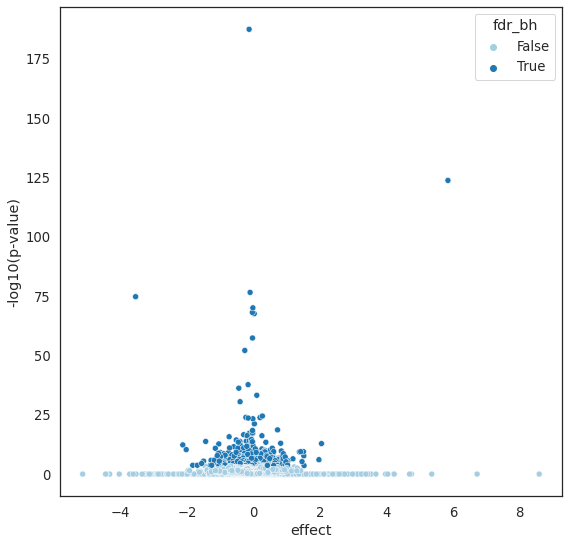

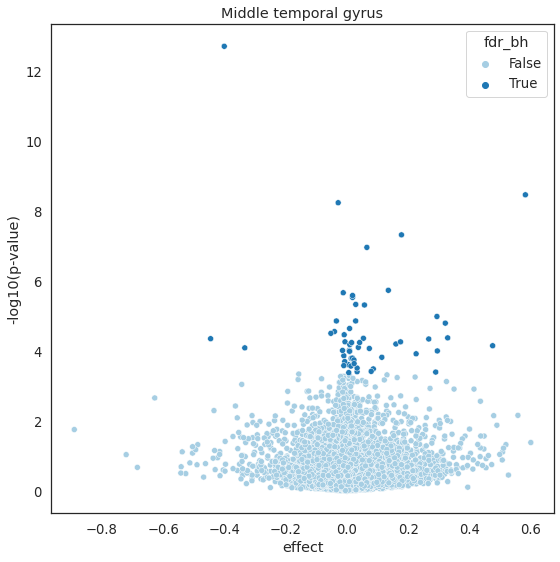

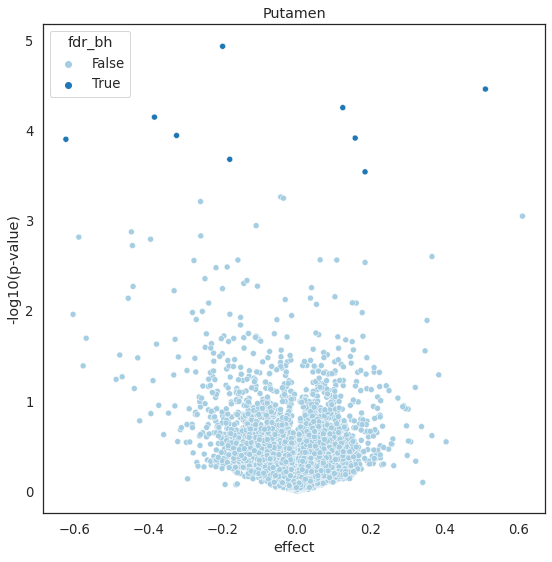

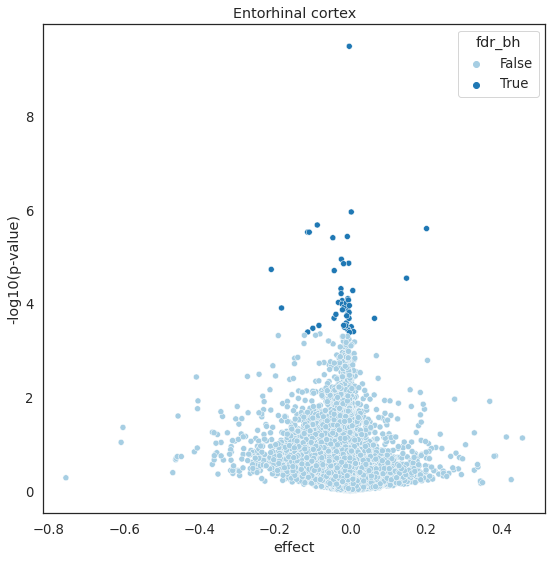

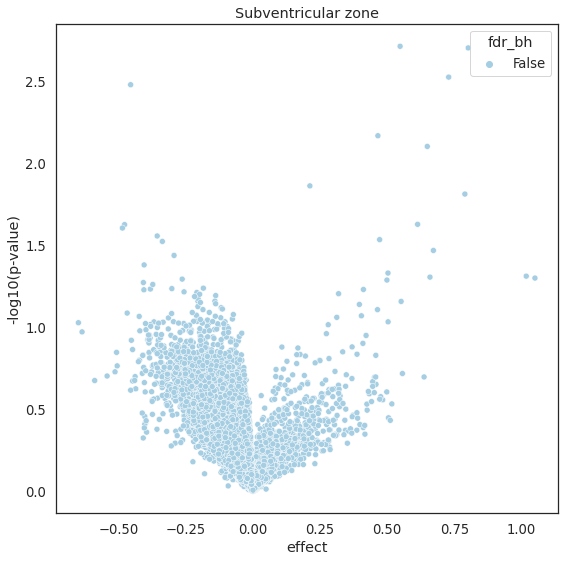

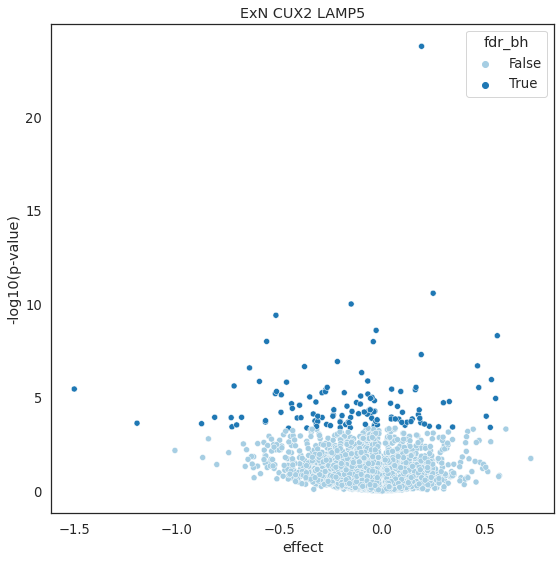

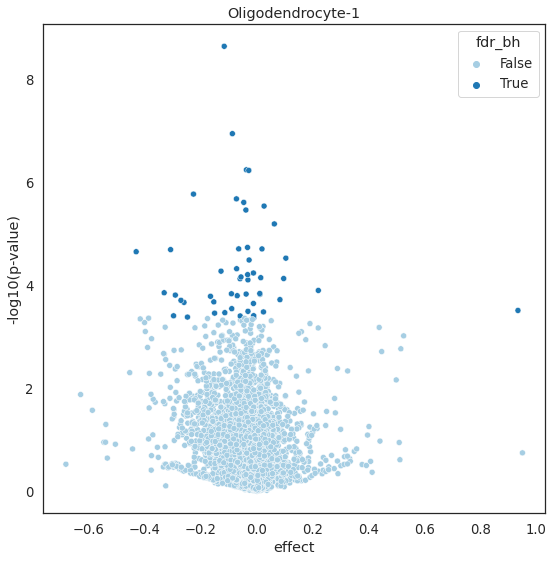

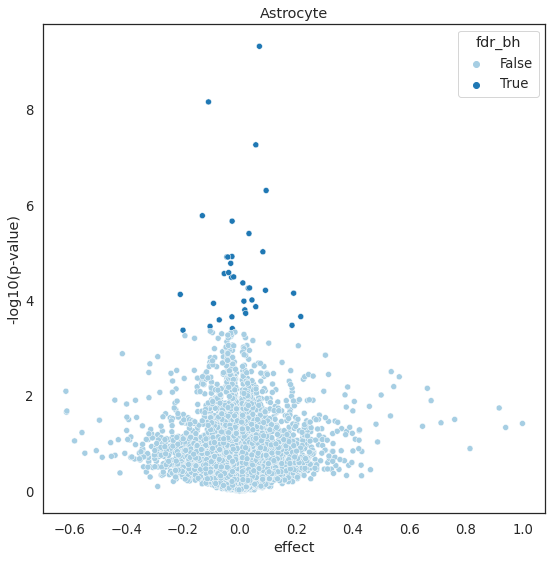

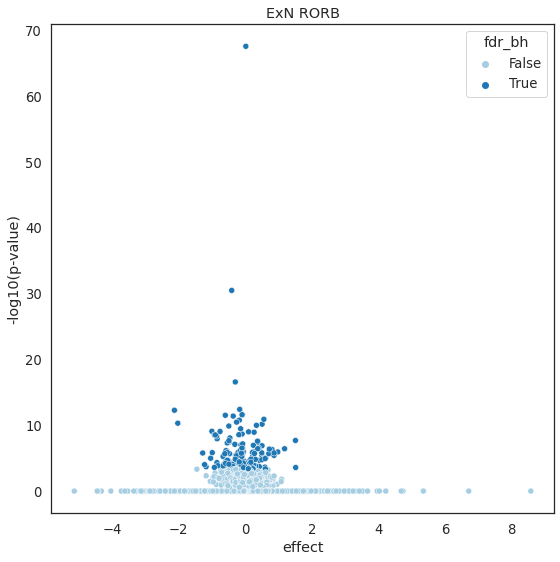

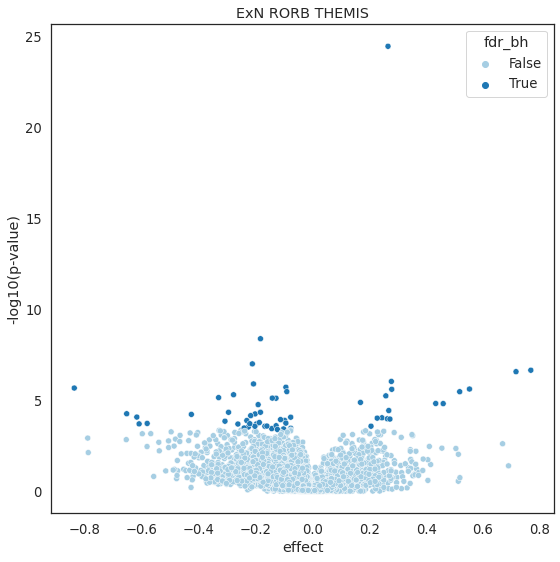

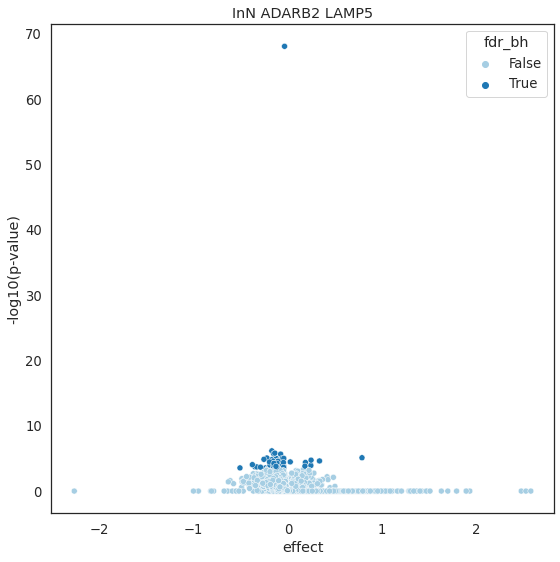

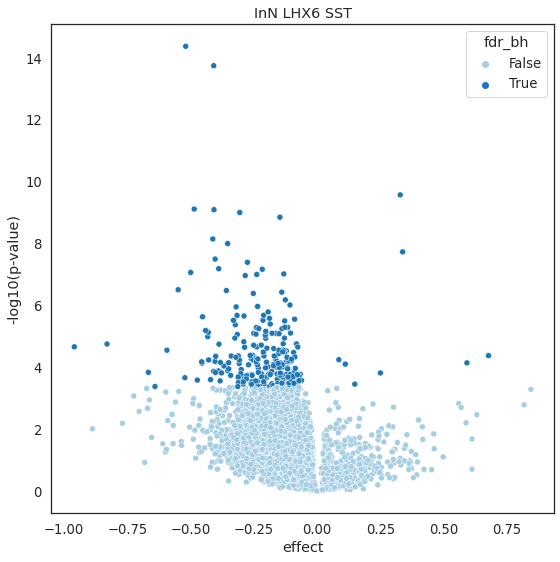

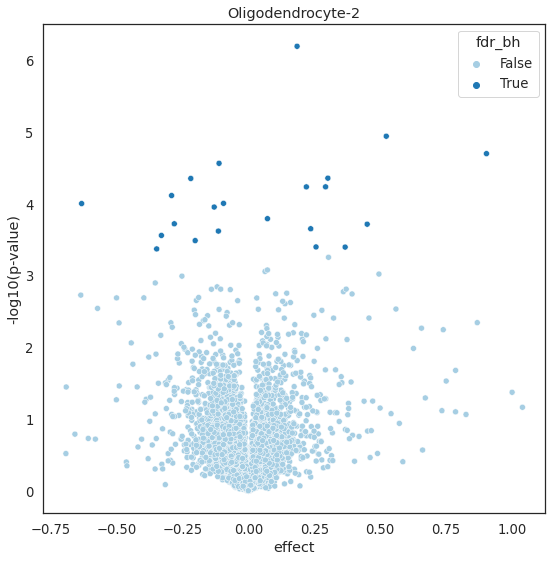

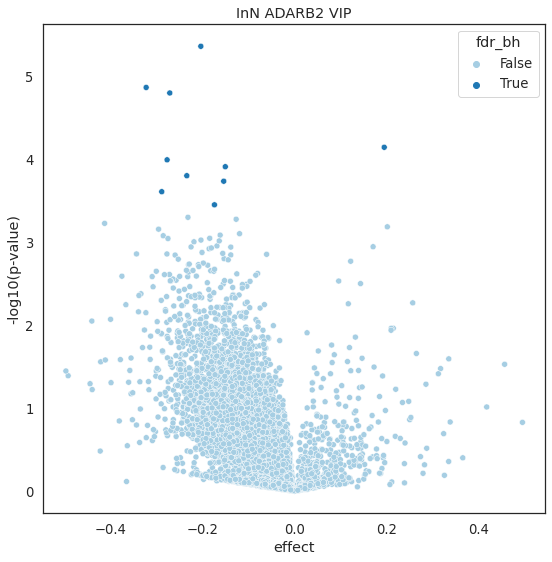

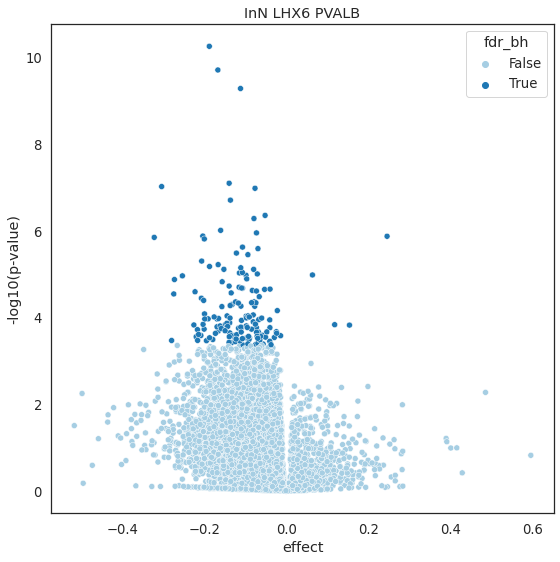

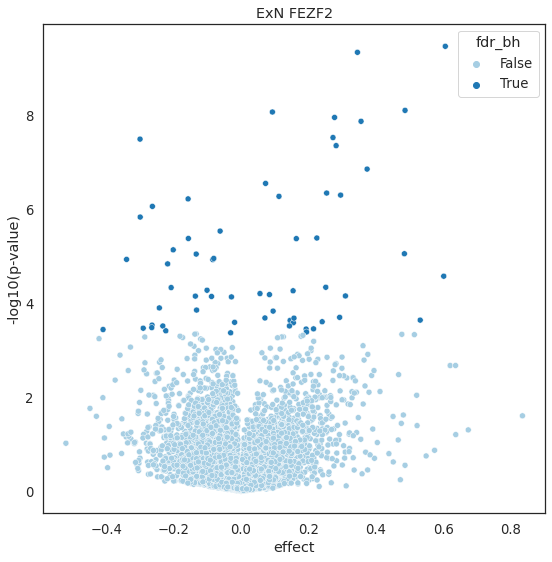

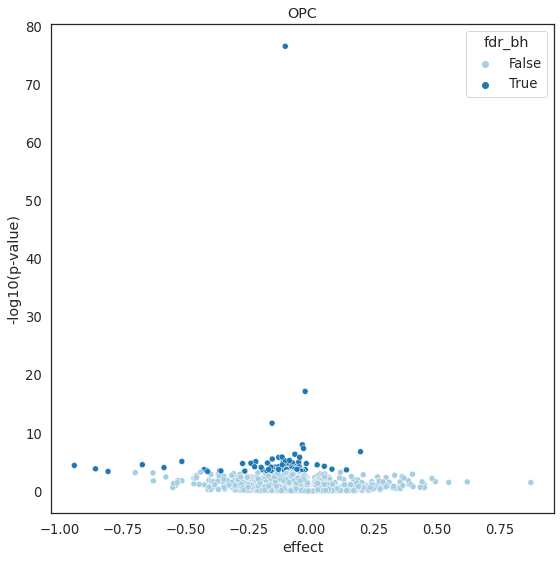

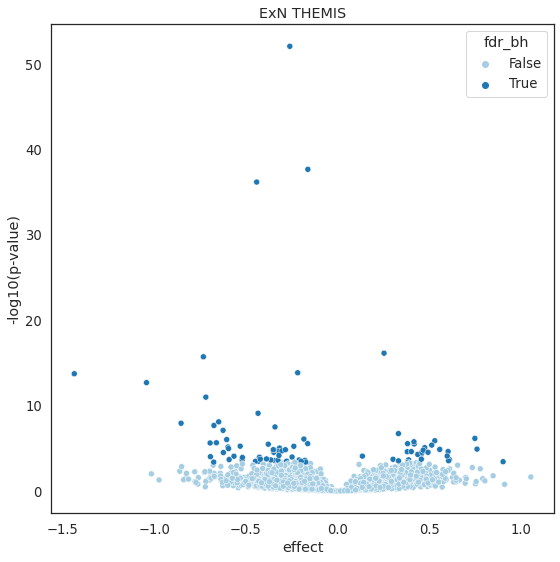

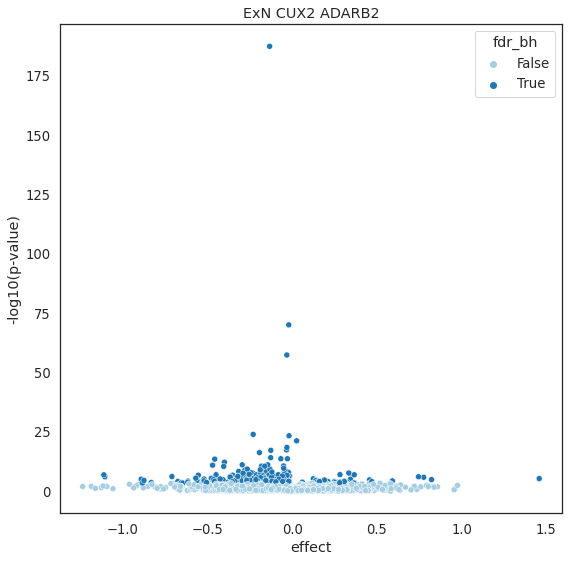

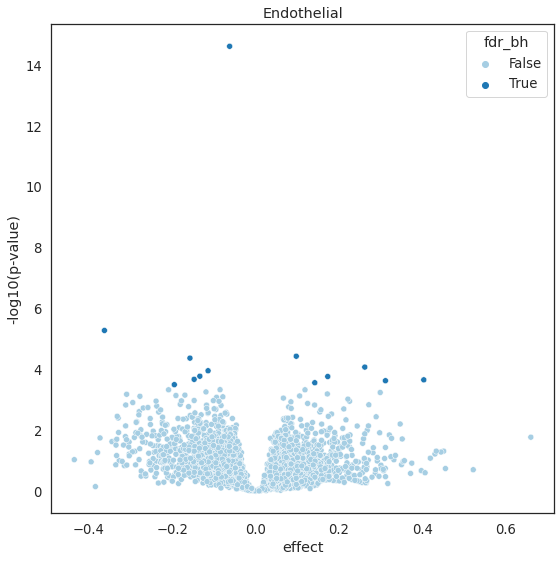

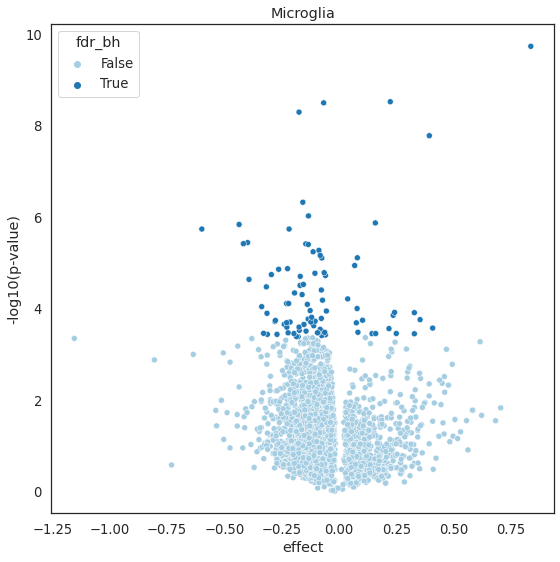

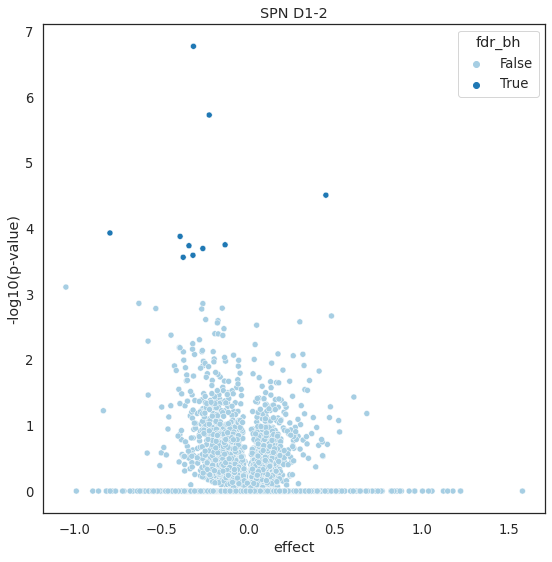

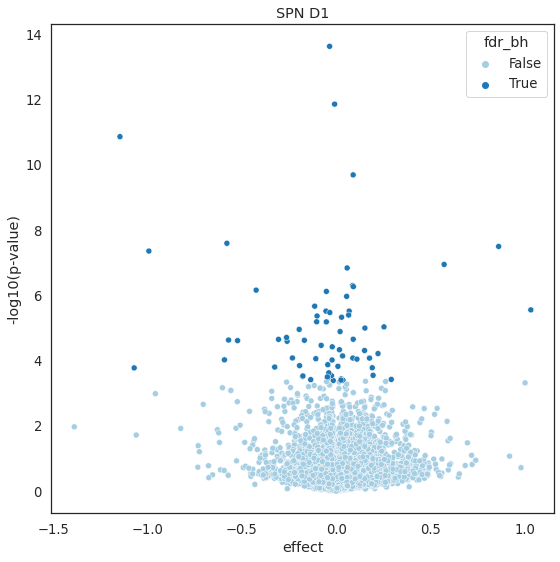

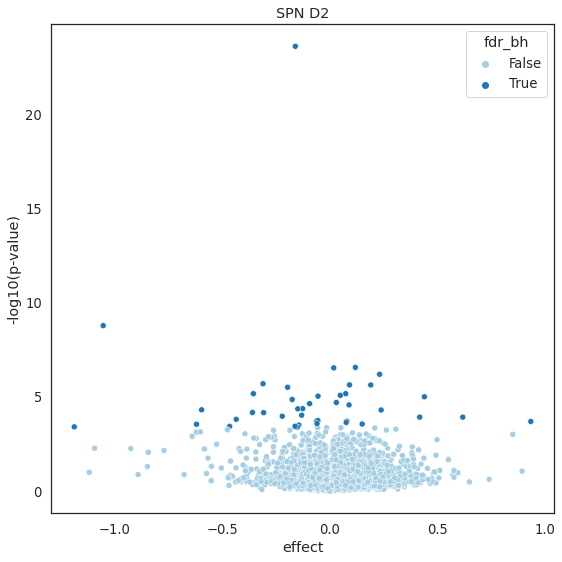

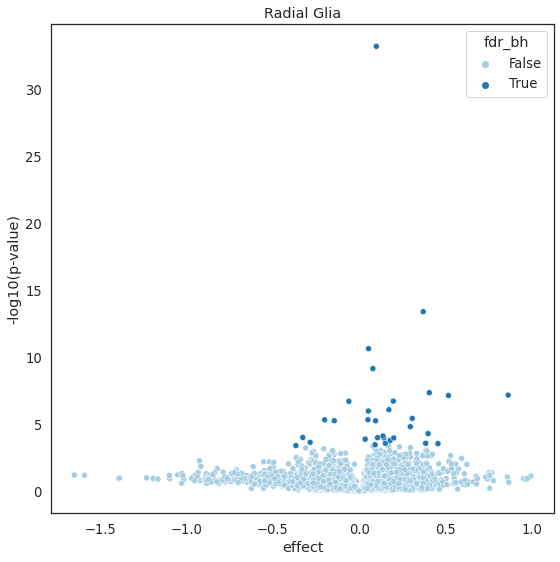

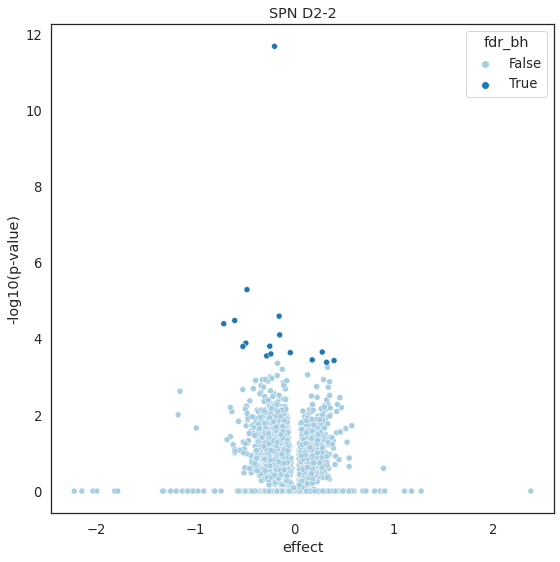

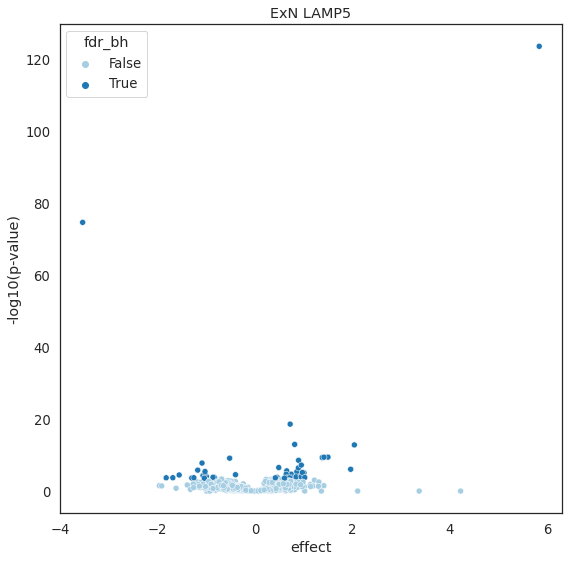

In [20]:
volcano_plot(glmm_results)

for tissue in glmm_results['tissue'].unique():
    volcano_plot(glmm_results.loc[glmm_results['tissue'] == tissue], title=tissue)

In [21]:
glmm_results.head()

,feature,intercept,coef,stderr,z,p-value,log2_fc,tissue,type,fdr_bh
0,CLMAT3,0.027721,-0.008033,0.005942,-1.351831,0.176430,-0.493672,Middle temporal gyrus,brain_region,0.662670
1,SLC26A11,0.339170,0.130978,0.037491,3.493591,0.000477,0.471106,Middle temporal gyrus,brain_region,0.052653
2,AP002381.2,0.207773,0.025675,0.028384,0.904562,0.365698,0.168093,Middle temporal gyrus,brain_region,0.828004
3,TEX10,0.668419,0.021417,0.081008,0.264377,0.791489,0.045500,Middle temporal gyrus,brain_region,1.000000
4,COQ5,0.215407,0.000930,0.014507,0.064107,0.948885,0.006215,Middle temporal gyrus,brain_region,1.000000


#### look at some of the individual results

feature           DPH6
intercept    -0.372559
coef          3.667707
stderr            -0.0
z                 -inf
p-value            0.0
log2_fc            NaN
tissue       ExN LAMP5
type         cell_type
fdr_bh             0.0
Name: 324, dtype: object


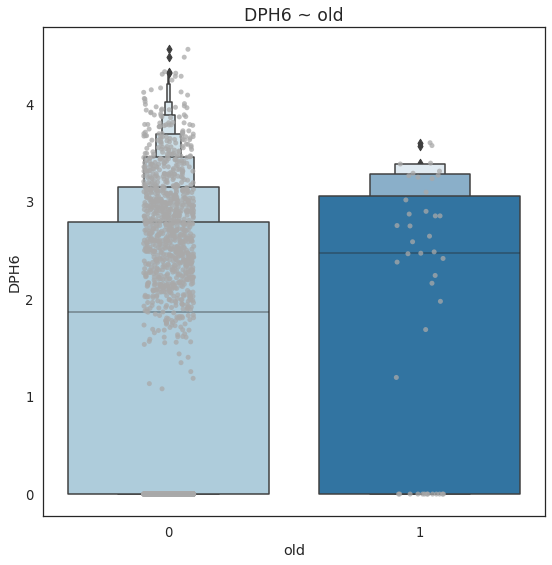

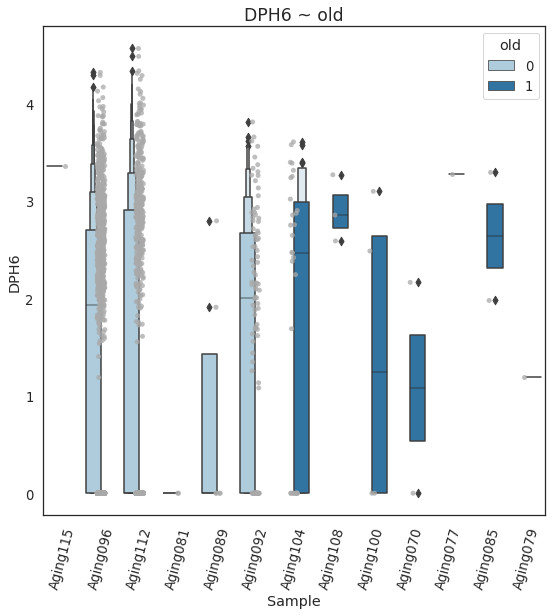

feature           DPH6
intercept    -0.372559
coef          3.667707
stderr            -0.0
z                 -inf
p-value            0.0
log2_fc            NaN
tissue       ExN LAMP5
type         cell_type
fdr_bh             0.0
Name: 324, dtype: object


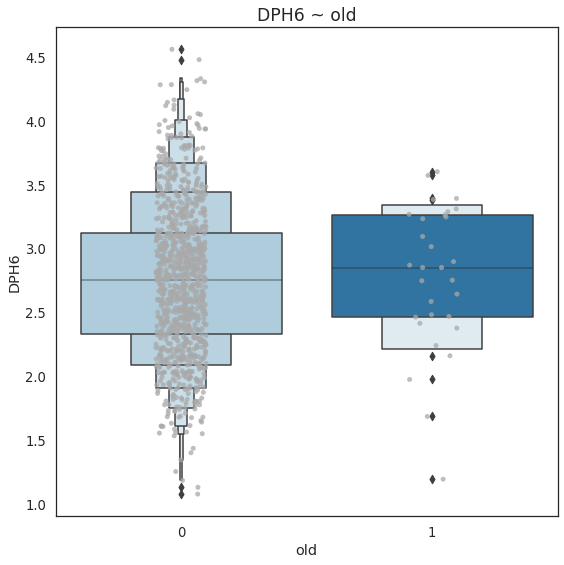

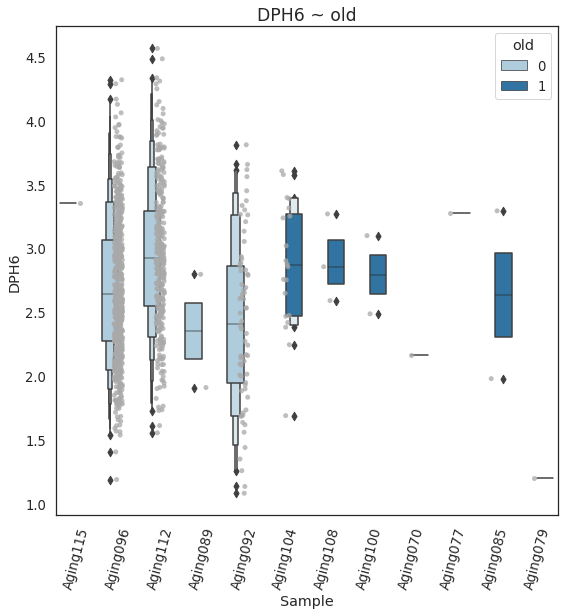

In [22]:
# max significant by p-value
this_results = glmm_results.loc[glmm_results['p-value'] == min(glmm_results['p-value'])]
this_hit = this_results.sort_values(by=['coef'], ascending=False).iloc[0]
prep_plot_feature(adata, this_hit)
prep_plot_feature(adata, this_hit, filter_zeros=True)

feature           CHL1
intercept     0.076904
coef         -3.543446
stderr        0.192798
z           -18.379017
p-value            0.0
log2_fc            NaN
tissue       ExN LAMP5
type         cell_type
fdr_bh             0.0
Name: 865, dtype: object


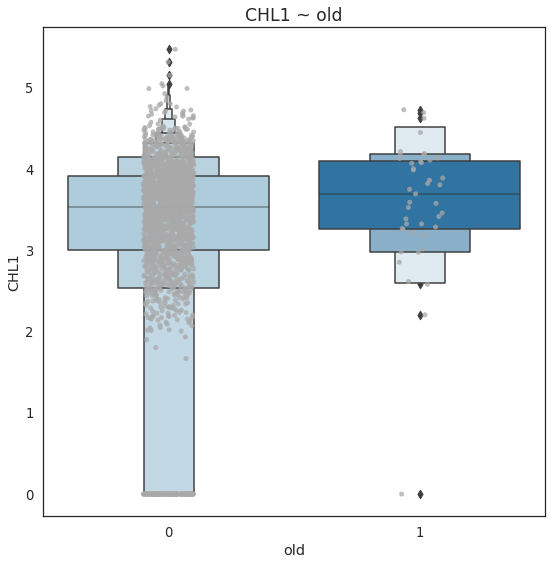

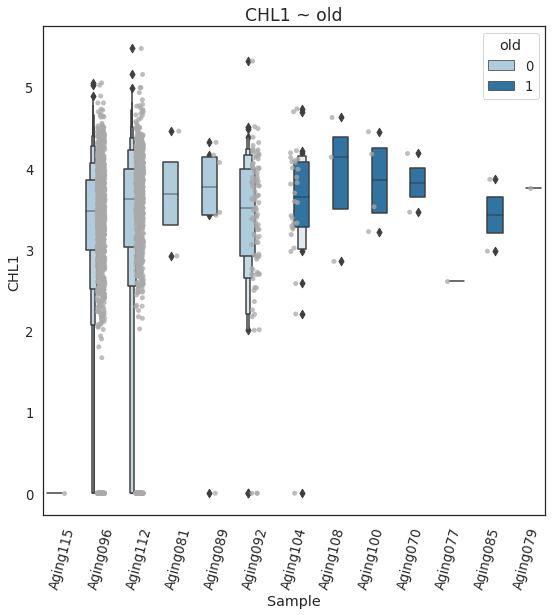

feature           CHL1
intercept     0.076904
coef         -3.543446
stderr        0.192798
z           -18.379017
p-value            0.0
log2_fc            NaN
tissue       ExN LAMP5
type         cell_type
fdr_bh             0.0
Name: 865, dtype: object


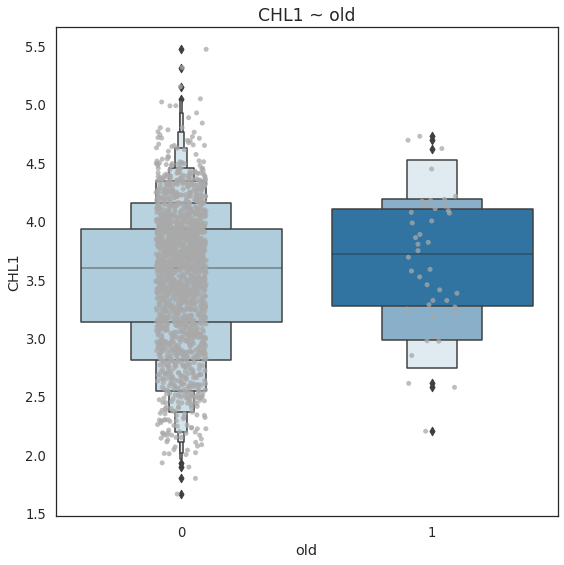

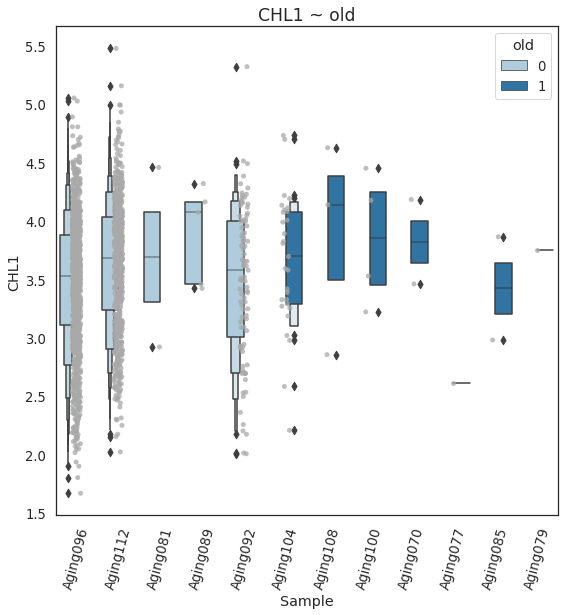

In [23]:
# min significant by coef (increasing)
sig_results = glmm_results.loc[glmm_results['fdr_bh'] < 0.05]
this_results = sig_results.loc[sig_results['coef'] == min(sig_results['coef'])]
this_hit = this_results.sort_values(by=['coef'], ascending=False).iloc[0]
prep_plot_feature(adata, this_hit)
prep_plot_feature(adata, this_hit, filter_zeros=True)

feature                  LINC02241
intercept                 0.130128
coef                     -0.052146
stderr                    0.012516
z                        -4.166203
p-value                   0.000031
log2_fc                  -0.738727
tissue       Middle temporal gyrus
type                  brain_region
fdr_bh                     0.00881
Name: 7342, dtype: object


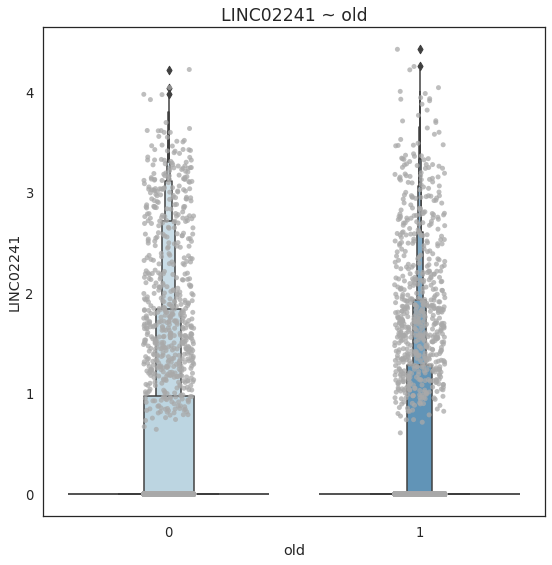

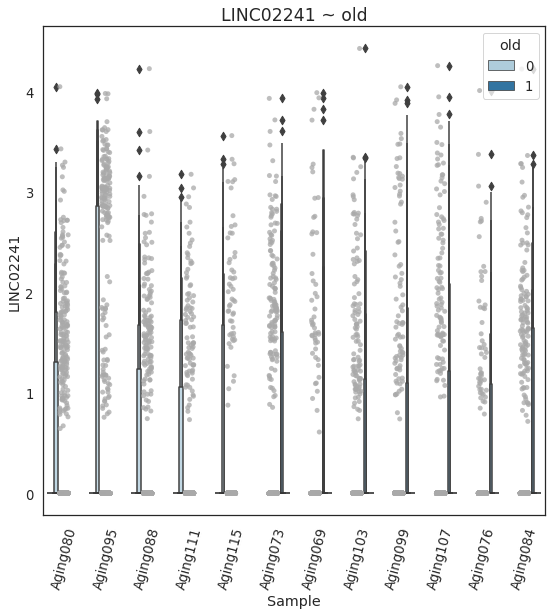

feature                  LINC02241
intercept                 0.130128
coef                     -0.052146
stderr                    0.012516
z                        -4.166203
p-value                   0.000031
log2_fc                  -0.738727
tissue       Middle temporal gyrus
type                  brain_region
fdr_bh                     0.00881
Name: 7342, dtype: object


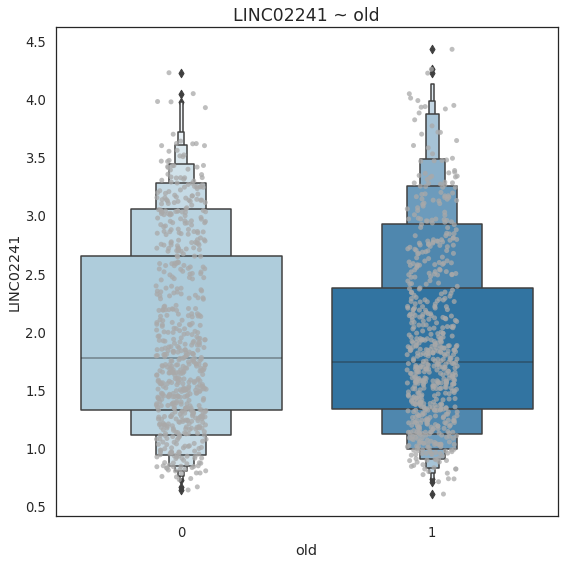

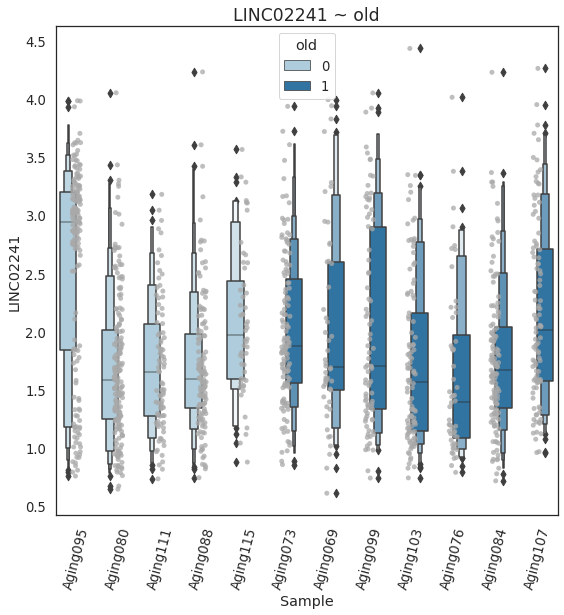

In [24]:
# random
this_hit = sig_results.sample().iloc[0]
prep_plot_feature(adata, this_hit)
prep_plot_feature(adata, this_hit, filter_zeros=True)

feature               ASIC2
intercept         -0.637963
coef               8.583774
stderr       1561853.256399
z                  0.000005
p-value            0.999996
log2_fc                 NaN
tissue             ExN RORB
type              cell_type
fdr_bh                  1.0
Name: 2928, dtype: object


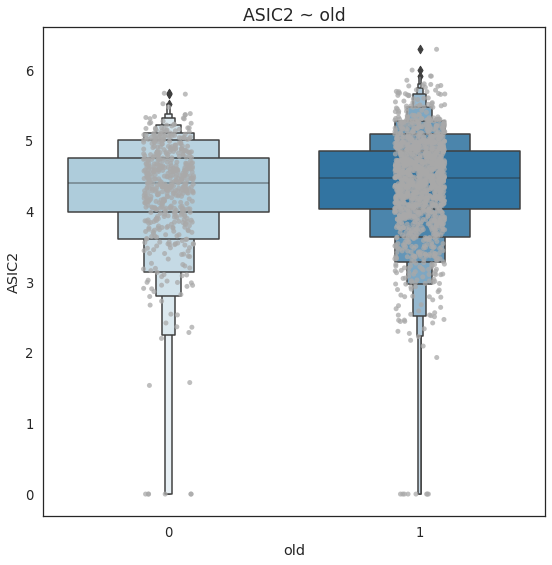

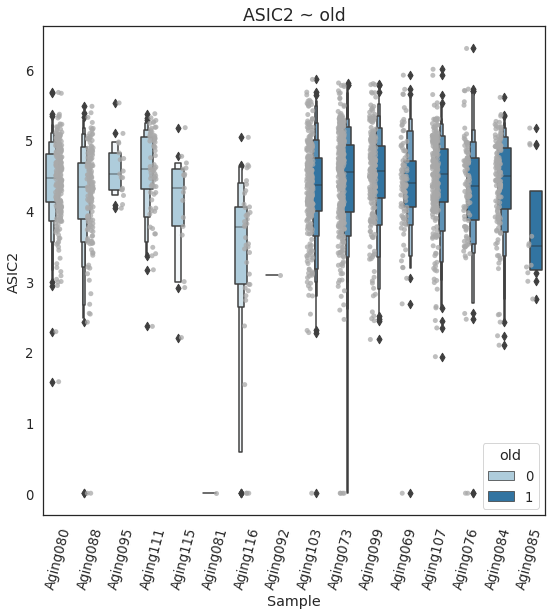

feature               ASIC2
intercept         -0.637963
coef               8.583774
stderr       1561853.256399
z                  0.000005
p-value            0.999996
log2_fc                 NaN
tissue             ExN RORB
type              cell_type
fdr_bh                  1.0
Name: 2928, dtype: object


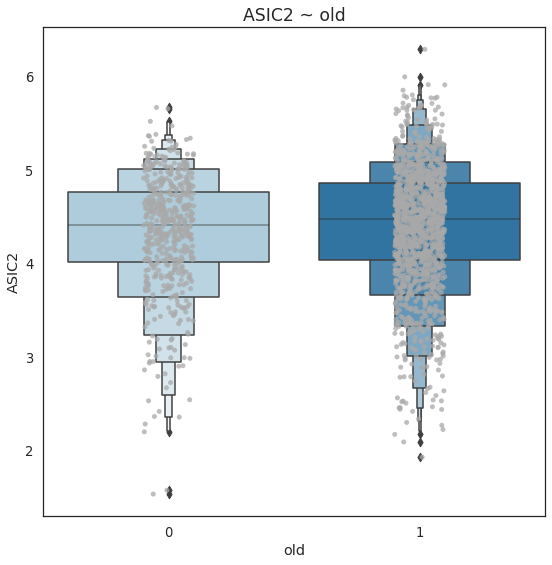

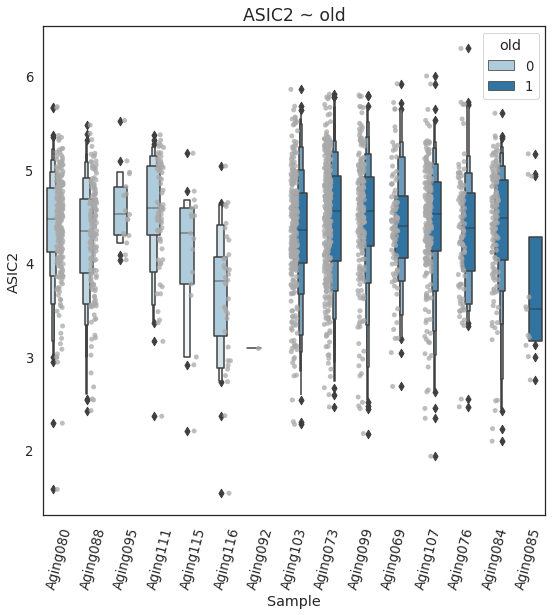

In [25]:
# max non-significat by coef (increasing)
nonsig_results = glmm_results.loc[(glmm_results['fdr_bh'] > 0.05) & 
                                     (~glmm_results['z'].isna())]
this_results = nonsig_results.loc[nonsig_results['coef'] == max(nonsig_results['coef'])]
this_hit = this_results.sort_values(by=['coef'], ascending=True).iloc[0]
prep_plot_feature(adata, this_hit)
prep_plot_feature(adata, this_hit, filter_zeros=True)